# PLAYGROUND

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # force CPU usage

import keras
from sklearn.manifold import TSNE
from src.EEGModalNet.data.dataloader import LEMONEEGDataModule
from src.EEGModalNet.models.gan import SimpleGAN
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
from src.EEGModalNet.utils import ProgressBarCallback
from tqdm.auto import tqdm

# helper functions
def train_model(model, x, max_epochs, early_stopping=True, logger_dir='tmp/keras_logs/simple_gan_v1.csv', patience=100):
    reusable_pbar=tqdm(total=max_epochs, unit='epoch', leave=False, dynamic_ncols=True)
    
    model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
                d_optimizer=keras.optimizers.Adam(0.001),
                g_optimizer=keras.optimizers.Adam(0.0001))
    
    callbacks = [keras.callbacks.CSVLogger(logger_dir),
                 ProgressBarCallback(n_epochs=max_epochs, n_runs=1, run_index=0, reusable_pbar=reusable_pbar)]
    if early_stopping:
        callbacks.append(keras.callbacks.EarlyStopping(monitor='d_loss', mode='min', patience=patience))

    history = model.fit(
        x,
        epochs=max_epochs,
        verbose=0, # type: ignore
        shuffle=True,
        callbacks=callbacks
    )
    return history

def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['d_loss'], label='discriminator')
    plt.plot(history.history['g_loss'], label='generator')
    plt.legend()
    plt.show()

def plot_losses(history, loss='g_loss', s=30):
    loss = history.history[loss]
    loss = pd.Series(loss).rolling(s).mean()
    plt.plot(loss)
    # add the mean of g_loss to the plot as a text
    mean = loss.mean()
    # plt.text(len(loss)-90, mean, f'mean={mean:.3f}', fontsize=12)

## GAN

In [ ]:
# parameters
n_features = 10
latent_dim = 64

# data
data = MockTemporalData(n_samples=20, n_features=n_features, n_timepoints=100)
x, _ = data()

# model
model = SimpleGAN(time_dim=100, feature_dim=n_features, latent_dim=latent_dim)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

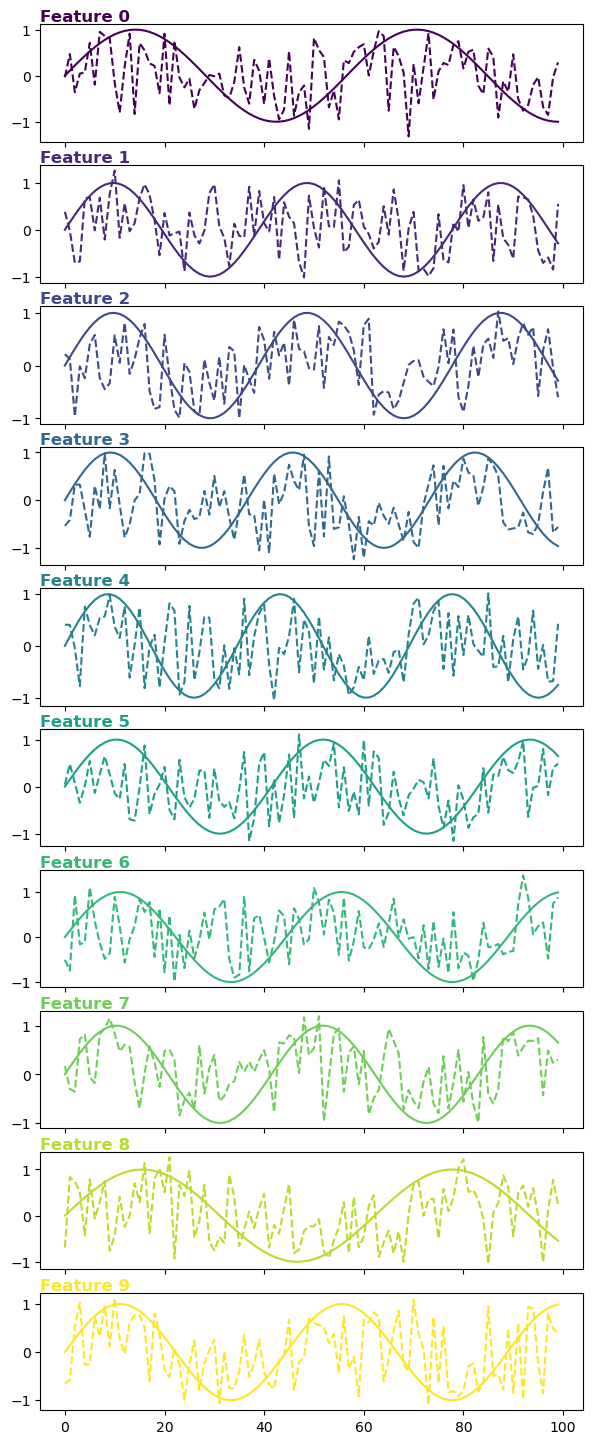

In [40]:
from matplotlib import pyplot as plt
import numpy as np
subject_to_plot = 0
feature_to_plot = range(n_features)
noise = keras.random.normal((1, latent_dim))
x_gen = model.generator(noise)
# pick colors based on the number of features
colors = plt.cm.viridis(np.linspace(0, 1, n_features))
# share x axis

fig, axes = plt.subplots(n_features, 1, figsize=(7, 1.8*n_features), sharex=True)
for i, (c, f) in enumerate(zip(colors, feature_to_plot)):
    axes[i].plot(x[subject_to_plot, :, f], label='real', color=c)
    axes[i].plot(x_gen[subject_to_plot, :, f].cpu().detach().numpy().squeeze(), label='generated', color=c, linestyle='--')
    axes[i].set_title(f'Feature {f}', fontsize=12, fontweight='bold', color=c, loc='left', verticalalignment='top')
plt.show()

## Load model from checkpoints

In [ ]:
from src.EEGModalNet.models import SimpleGAN
model = SimpleGAN(time_dim=100, feature_dim=1, latent_dim=64)
model.load_weights('tmp/keras_models/simple_gan_v1_HPC.model.keras')

## Train with Real Data

### Timeseries

In [ ]:
data = LEMONEEGDataModule(n_subjects=1).prepare_data()
x = data.train_dataset['x'].mean(axis=2)[20:40]
x = x[np.newaxis, 19, :, np.newaxis].repeat(20, axis=0)

model = SimpleGAN(time_dim=128, feature_dim=1, latent_dim=100)
history = train_model(model, x, max_epochs=1000, early_stopping=True, patience=200)

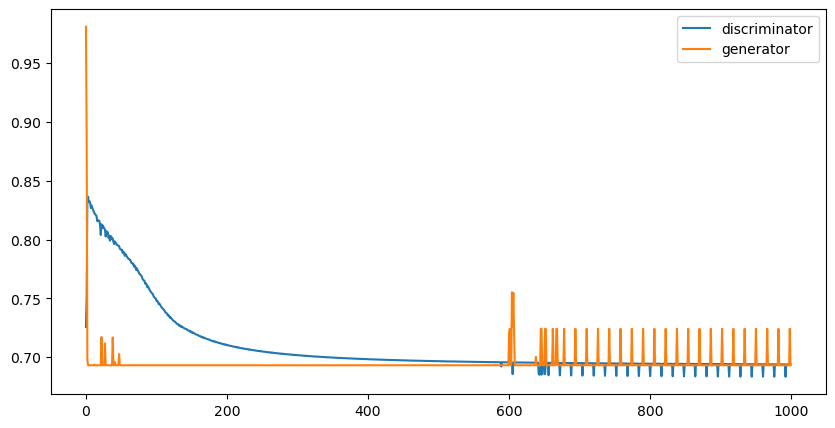

In [14]:
plot_history(history)

In [23]:
from keras import layers
input_layer = keras.Input(shape=(100,))
x = layers.Reshape((1, 100))(input_layer)
x = layers.Conv1D(128, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(256, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Conv1D(512, 3, padding='same')(x)
x = layers.LeakyReLU(negative_slope=0.2)(x)
x = layers.Dense(128 * 1)(x)
x = layers.Reshape((128, 1))(x)

# Residual connections
x = layers.Add()([x, input_layer])

generator = keras.Model(inputs=input_layer, outputs=x, name='generator')

generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_19          │ (None, 1, 100)    │          0 │ input_layer_16[0… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 1, 128)    │     38,528 │ reshape_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_28      │ (None, 1, 128)    │          0 │ conv1d_28[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 1, 256)    │     98,560 │ leaky_re_lu_28[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_29      │ (None, 1, 256)    │          0 │ conv1d_29[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 1, 512)    │    393,728 │ leaky_re_lu_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_30      │ (None, 1, 512)    │          0 │ conv1d_30[0][0]   │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 1, 128)    │     65,664 │ leaky_re_lu_30[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_20          │ (None, 128, 1)    │          0 │ dense_27[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 128, 100)  │          0 │ reshape_20[0][0], │
│                     │                   │            │ input_layer_16[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 596,480 (2.28 MB)

 Trainable params: 596,480 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

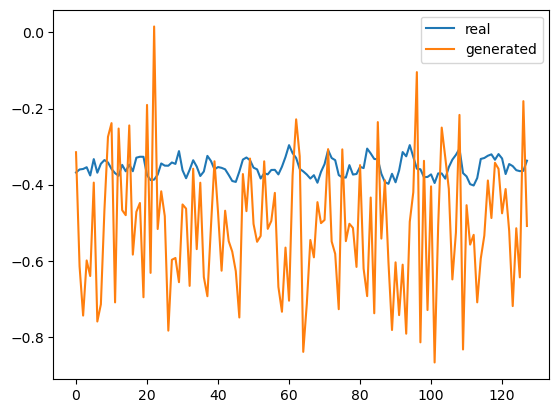

x_gen: tensor([[2.2815e-08]], device='mps:0', grad_fn=<SigmoidBackward0>) 
x: tensor([[2.4916e-06],
        [1.7067e-06],
        [4.6856e-06],
        [3.0696e-06],
        [3.0497e-06],
        [3.9594e-06],
        [4.0675e-06],
        [4.0047e-06],
        [2.3811e-06],
        [2.7084e-06],
        [5.1155e-06],
        [3.3875e-06],
        [3.2467e-06],
        [1.7339e-06],
        [1.4052e-06],
        [2.3473e-06],
        [3.5508e-06],
        [2.2990e-06],
        [3.0505e-06],
        [2.6173e-06]], device='mps:0', grad_fn=<SigmoidBackward0>)


In [61]:
x_gen = model.generator(keras.random.normal((1, 64)))
b_to_plot = 10
plt.plot(x[b_to_plot, :], label='real')
plt.plot(x_gen.cpu().detach().numpy().squeeze(), label='generated')
plt.legend()
plt.show()
print('x_gen:', model.discriminator(x_gen), '\nx:', model.discriminator(x))

It seems that the discriminator does not learn to tell the generated from the real models apart. Also the generated data is similar to noise, and we cannot tell if it has ever learned anything unless we check if they show similar properties such as their mean, variance, power spectrum, etc. Then we switch to using a simpler data, for example the wavelets instead of raw data in the next section.
The second solution might be making the generator more complex, for example by adding more layers, or using a different architecture therefore it could learn the nauances of the data better.

### Wavelets

In [ ]:
# data
wavelets = xr.open_dataarray('data/LEMON_data/wavelets.nc5')
x = wavelets.sel(subject=wavelets.subject[0]).to_numpy()
# x = np.moveaxis(x, 0, -1)
x = x[np.newaxis, :, 0:2]

# model
model = SimpleGAN(time_dim=61, feature_dim=2, latent_dim=64)
history = train_model(model, x, max_epochs=10000, early_stopping=True)

In [88]:
x_gen = model.generator(keras.random.normal((1, 64)))
model.discriminator(x_gen), model.discriminator(x)

(tensor([[1.]], device='mps:0', grad_fn=<SigmoidBackward0>),
 tensor([[8.9189e-10]], device='mps:0', grad_fn=<SigmoidBackward0>))

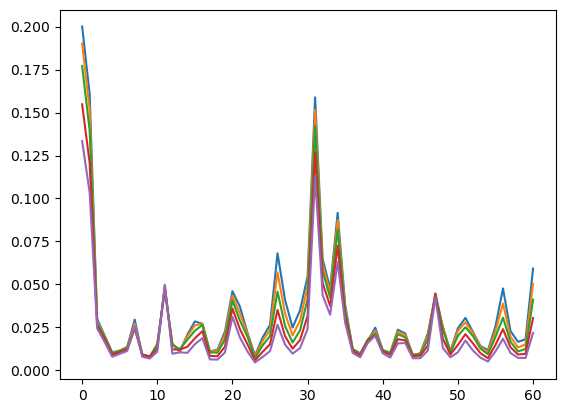

In [11]:
for i in range(5, 10):
    plt.plot(x[:, i], label='real')
plt.show()

*Observation 1*: The discriminator works really fine in telling the generated from real data apart. However, the generator does not produce realistics data (it might make the job easy for the discriminator).

*Observation 2*: From the amplitude of the wavelets, plotted across 61 channels we can see that there is definetly a problem with these values. They are completely out of range, so maybe the mere normaliation might help. Also the EEG data might need some steps to be preprocessed, such as filtering, or removing the artifacts.

**Next Steps:**

- As the first step, I made my data much simpler: instead of having 61 channels or so I only included the power spectrum from 2 channels.

- or a timeseries data, but all the samples would be the same.

- Second step would be extracting time-frequency data, instead of only having the power of each frequency bin. In this case, I'd like to see if the model can generate the sinusoidal waves with different frequencies and amplitudes.

- Next step would be changing the architecture of the generator and discriminator, for example adding more layers, and leveraging the power of the convolutional neural networks, batch normalizations and residual connections for the generator.

- In the end, I'd train a convolusional GAN which impose a more complex task to the discriminator to solve.

## WGAN

In [2]:
from src.EEGModalNet.models.WGAN import WGAN_GP

In [13]:
# data
training = True
path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
data = xr.open_dataarray(path, engine='h5netcdf')
x = data.sel(subject=data.subject[19]).to_numpy()
x = x[np.newaxis, [27, 28], 3200:3500].repeat(20, axis=0)
x = np.moveaxis(x, 2, 1)

# unfold the time dimension
# x = torch.tensor(x).unfold(1, 600, 600).permute(1, 2, 0)

# Instantiate and compile the model
wgan_gp = WGAN_GP(time_dim=300, feature_dim=2, latent_dim=64)

if training:
    generator_optimizer = keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9)
    discriminator_optimizer = keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9)

    wgan_gp.compile(
                    d_optimizer=discriminator_optimizer,
                    g_optimizer=generator_optimizer,
                    gradient_penalty_weight=1.0)

    history = wgan_gp.fit(x, epochs=200)
else: # load weights
    wgan_gp.load_weights('tmp/keras_models/wgan_gp_v1_realDATA.model.keras')

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step - d_loss: 0.8248 - g_loss: 0.2216
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - d_loss: -1.7498 - g_loss: 0.4115
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - d_loss: -3.5074 - g_loss: 0.6439
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - d_loss: -5.2106 - g_loss: 0.9620
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: -6.7914 - g_loss: 1.2945
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - d_loss: -8.2399 - g_loss: 1.5726
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - d_loss: -9.6288 - g_loss: 1.8962
Epoch 8/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - d_loss: -11.4713 - g_loss: 2.3849
Epoch 9/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - d_loss: -13.2413 - g_loss: 2.7134
Epoch 10/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - d_loss: -14.9361 - g_loss: 2.8878
Epoch 11/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - d_loss: -16.5276 - g_loss: 3.4255
Epoch 12/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/st

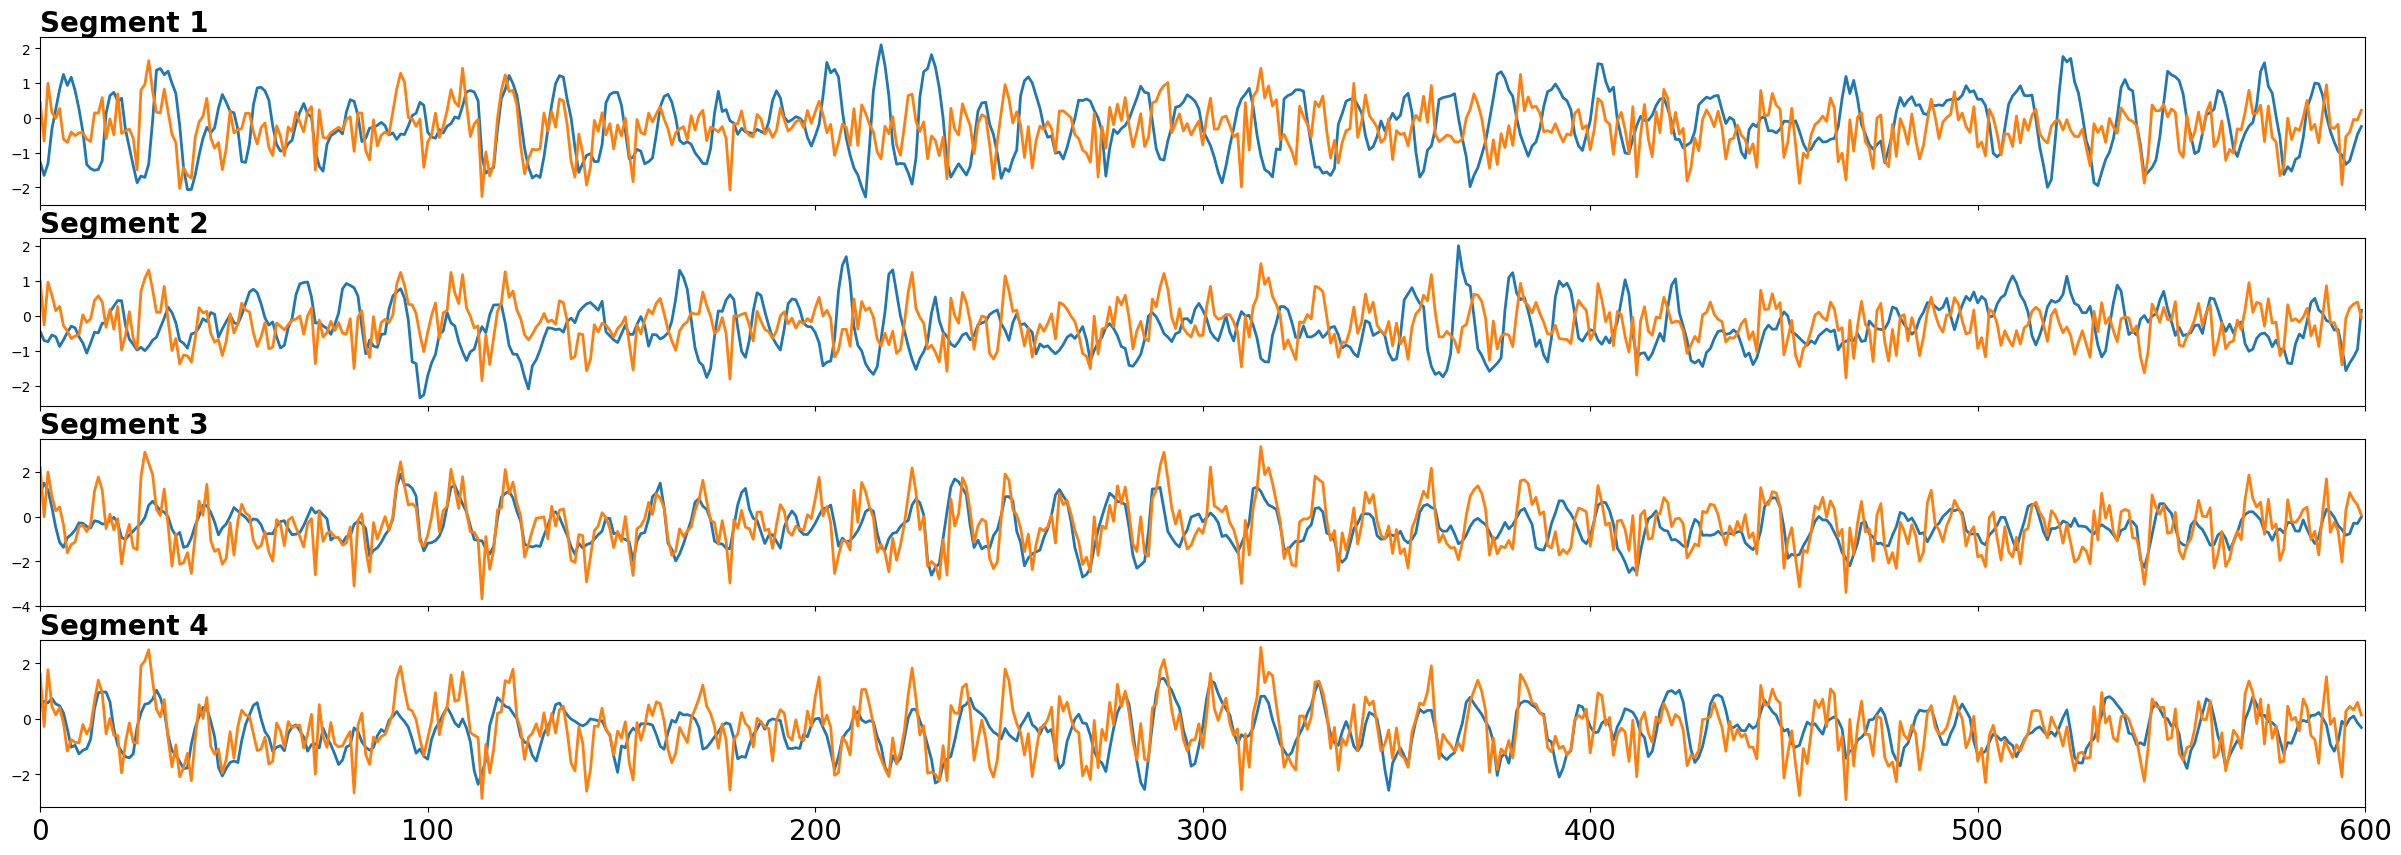

In [105]:
noise = torch.zeros(4, 200)
means = x.mean(dim=1).mean(dim=1)
stds = x.std(dim=1).mean(dim=1)
for i in range(x.shape[0]):
    noise[i] = keras.random.normal((200,), mean=means[i], stddev=stds[i])

x_gen = wgan_gp.generator(noise).cpu().detach().numpy()
n_seg = 4
fig, axes = plt.subplots(n_seg, 1, figsize=(30, 10), sharex=True)
for i in range(n_seg):
    axes[i].plot(x[i, :, 0], label='real', linewidth=2)
    axes[i].plot(x_gen[i, :, 0], label='generated', linewidth=2)
    axes[i].set_title(f'Segment {i+1}', fontsize=20, fontweight='bold', loc='left', verticalalignment='top')
plt.xticks(fontsize=20)
plt.xlim(0, 600)
plt.show()

In [83]:
wgan_gp.discriminator(x_gen), wgan_gp.discriminator(x)

(tensor([[0.1147],
         [0.1469],
         [0.9064],
         [0.8806]], device='mps:0', grad_fn=<SigmoidBackward0>),
 tensor([[0.9918],
         [0.9511],
         [0.9999],
         [0.9897]], device='mps:0', grad_fn=<SigmoidBackward0>))

In [ ]:
# plot overlap of the generated data
plt.figure(figsize=(30, 5))
colors = ['blue', 'red', 'green', 'magenta']
for i, c in enumerate(colors):
    plt.plot(x_gen[i, :, 0], color=c)
# plt.plot(x_gen.mean(axis=0), color='black', linewidth=4, linestyle='--', label='mean')
plt.xlim(0, 600)
plt.show()

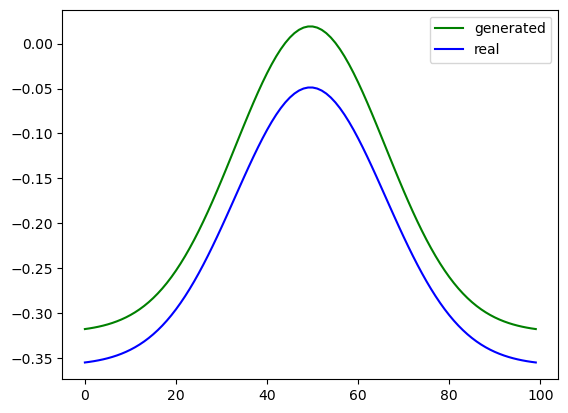

In [130]:
# plot a normal distribution given the mean and std of the real data
import scipy.stats as stats
l = np.linspace(-3, 3, 100)
z = stats.norm.pdf(l, loc=0, scale=1)
y = z * x_gen.std() + x_gen.mean()
b = z * x.std().numpy() + x.mean().numpy()
plt.plot(y, label='generated', color='green')
plt.plot(b, label='real', color='blue')
plt.legend()

**Observations:**

1. Decreasing landa (the wieght of the gradient penalty) from 10 to 1, imporved the performance of the generator when the mock data was used. However, the discriminator could not tell real from generated data apart. it could be due to the fact that the generator has become too powerful, and the discriminator could not learn to tell the difference.

2. When using the real data, especially data with 300 timepoints from O1 and O2 channels from only one subject, that would exhibit sinusoidal alpha waves during the eyes closed state, generator did a great job in generating the data that looks like the real data, while discriminator could also tell the difference. However, when I used data from Fp1 and Fp2 channels, which are more complicated, the loss of discriminator converged to 1 after 500 epochs, and the generator loss also converged to a negative value relatively fast and stayed the same. This might be due to the fact that the generator could not learn the nauances of the data, and the discriminator could not tell the difference.

3. I retrained the data with O1 and O2 and was able to replicate the good performance of the generator but not the discriminator. If the discriminator could not classify real from fake data how can we expect it to understand the underlying structure of different classes later when using conditional GANs? This is an important point. Maybe we need to freeze the generator after training and focus on the discriminator.

4. I retrained the data increasing the wieght of the gradient penalty and guess what generator can now produce more realistic data, but not completely matching. the discriminator still do a tribble job and intrestingly it always output probbality of 0.4746 for both real or fake x, which is equal to the absolute value of the generator's loss the point it converged and stayed fast. The discriminator also converged to point 4 and stayed there. 

5. there are two ways of calculating gradients: using the adam optimizer in keras or pytorch optimizers and the corresponding codes. I tried both for my best performing model so far and the result was the same.

6. The effect of batch normalizations within the generator: it does not impact neither the performance of discriminator nor the generator

7. latent dim should be a function of the number of timepoints or the complexity of the signal, the longer the signal segments and the higher the power of the higher frequencies such as gamma the bigger the value of the latent dim.
Similarly, the complexity of the network would be a function of the complexity of signal, to produce more complext data we need a network with higher capacity and greater number of layers stacked on each others

9. when we used four differnt samples of the data without repeating them, the model that was trained for 1500 steps always showed a matching-with-real data generation for one of the segments (segment 2 in above graph).

-- what would be the impact of changing the arch of the generator or discriminator?

### WGAN: increase number of subjects and channels

In [92]:
from src.EEGModalNet.models.WGAN import WGAN_GP
from scipy.signal import welch
import torch
import mne

sns.color_palette("viridis", as_cmap=True)
sns.set_style('darkgrid')

# Plotting helper functions
def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512):
    for i in range(n_seg):
        plt.figure(figsize=(2*n_seg, n_seg//2))
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512):
    plt.figure(figsize=(20, 2))
    for i in range(n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    plt.show()

def plot_psd(x, n_ch=5, lim=[20, 100]):
    for i in range(n_ch):
        f, Pxx = welch(x[i, :], fs=128, nperseg=2048, nfft=2048)
        plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]])
    plt.show()

def compare_psds(x, x_gen, lim=[20, 100], nperseg=2048, nfft=2048):
    f, Pxx = welch(x, fs=128, nperseg=nperseg, nfft=nfft)
    f_gen, Pxx_gen = welch(x_gen, fs=128, nperseg=nperseg, nfft=nfft)
    plt.plot(f[lim[0]:lim[1]], Pxx[lim[0]:lim[1]], label='real')
    plt.plot(f_gen[lim[0]:lim[1]], Pxx_gen[lim[0]:lim[1]], label='generated')
    plt.legend()
    plt.show()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

In [21]:
# data
time_dim = 512
n_subject = 20
training = 'continue'
net_path = 'tmp/keras_models/new_wgan_ch-Cz-sub-20_epo-110.model.keras'
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:20]).to_numpy()
# ch_list = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'Fz', 'Cz', 'Pz', 'Oz', 'F7', 'F8']
ch_list = ['Cz']
ch_ids = find_channel_ids(xarray, ch_list)
x = x[:, ch_ids, 440:]
x_filtered = mne.filter.filter_data(x, 128, 1, 42, method='fir', verbose=False)  # filter data
x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
sub = np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis]
# data = {'x': x, 'sub': sub}
x.shape

# #Instantiate and compile the model
# wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(ch_ids), latent_dim=64)

# if training == 'upload':
#     wgan_gp.load_weights(net_path)

# else:
#     if training == 'continue':
#         wgan_gp.load_weights(net_path)

#     wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
#                     g_optimizer=keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9),
#                     gradient_penalty_weight=1)

#     history = wgan_gp.fit(data, epochs=100)  # batch size = 32 better than 64

torch.Size([2380, 512, 1])

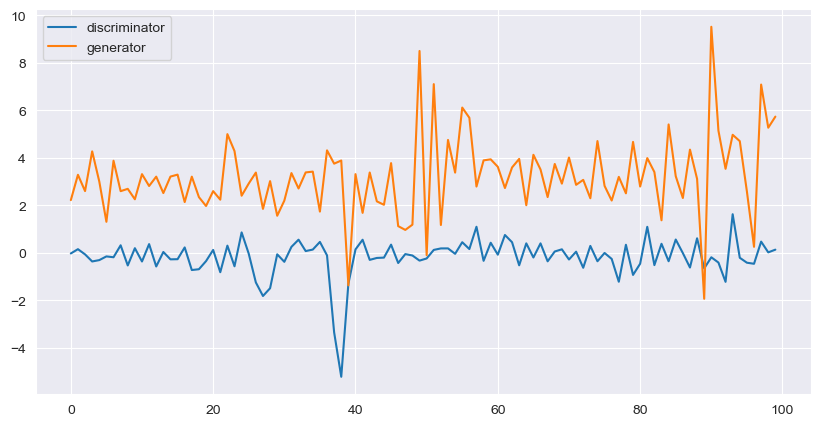

In [28]:
plot_history(history)

In [29]:
import math
gen_x = wgan_gp.generator(keras.random.normal((120, 64))).cpu().detach().numpy()
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
np.array([sigmoid(i) for i in wgan_gp.critic(gen_x)]).mean(), np.array([sigmoid(i) for i in wgan_gp.critic(x)]).mean()

(0.0604689836498388, 0.06176477308619421)

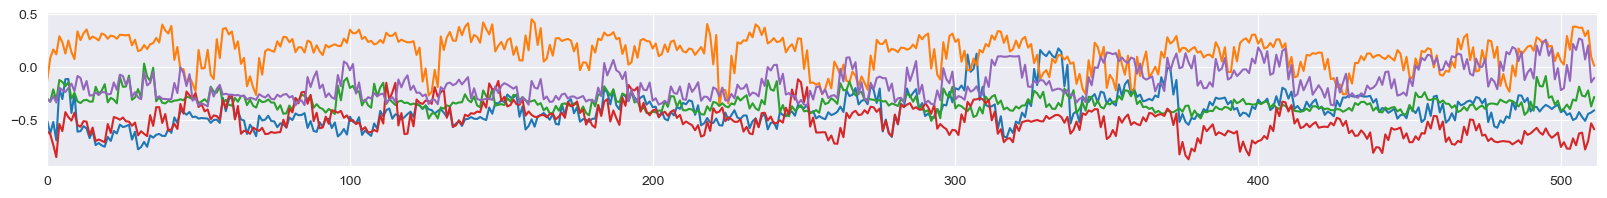

In [30]:
test_model = WGAN_GP(time_dim=512, feature_dim=16, latent_dim=64)
gen_x = wgan_gp.generator(keras.random.normal((2380, 64))).cpu().detach().numpy()
plot_overlap(gen_x, ch=0, n_seg=5)

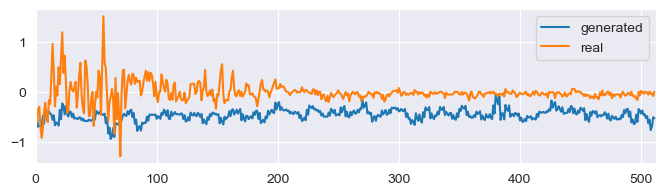

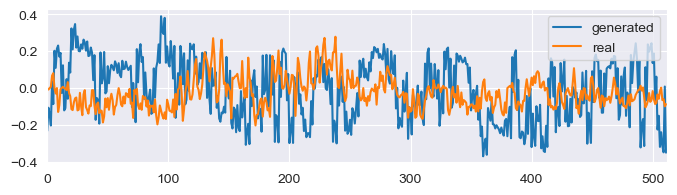

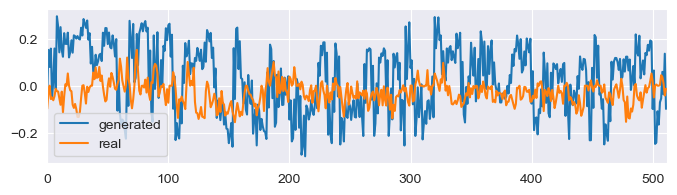

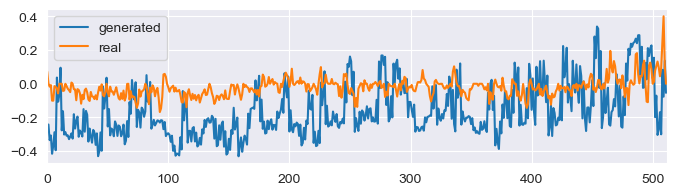

In [25]:
plot_onebyone(gen_x, x, n_seg=4, ch=0)

### Visual Evaluations of the Generated data
#### t-SNE

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 4800 samples in 0.001s...
[t-SNE] Computed neighbors for 4800 samples in 0.250s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4800
[t-SNE] Computed conditional probabilities for sample 2000 / 4800
[t-SNE] Computed conditional probabilities for sample 3000 / 4800
[t-SNE] Computed conditional probabilities for sample 4000 / 4800
[t-SNE] Computed conditional probabilities for sample 4800 / 4800
[t-SNE] Mean sigma: 0.592979
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.701492
[t-SNE] KL divergence after 1000 iterations: 1.761298


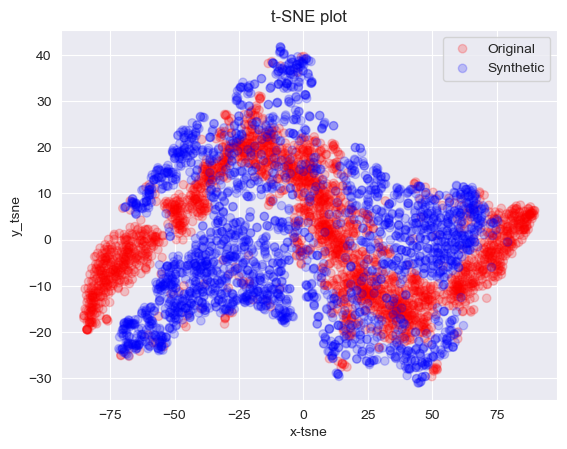

In [26]:
sample_len = len(x)
gen_x = wgan_gp.generator(keras.random.normal((sample_len, 64))).cpu().detach().numpy()
x_flat = x.mean(axis=2)
x_flat_hat = gen_x.mean(axis=2)

# Do t-SNE Analysis together       
x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)

# TSNE anlaysis
tsne = TSNE(n_components=2, verbose=1, perplexity=20)
tsne_results = tsne.fit_transform(x_flat_final)
    
# Plotting
f, ax = plt.subplots(1)
colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
    
plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
            c = colors[:sample_len], alpha = 0.2, label = "Original")
plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
            c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

ax.legend()
plt.title('t-SNE plot')
plt.xlabel('x-tsne')
plt.ylabel('y_tsne')
plt.show()

#### PSD

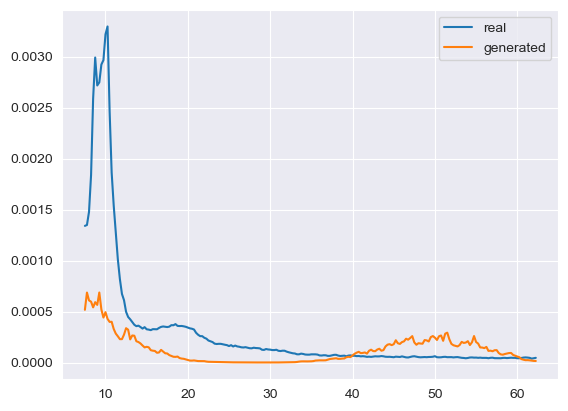

In [15]:
# x_ = xarray.sel(subject=xarray.subject[19]).to_numpy()
# x_ = x_[0, :]
x_ = np.hstack(x[:, :, 0])
x_gen = wgan_gp.generator(keras.random.normal((2380, 64))).cpu().detach().flatten(0, 1).squeeze().numpy()
compare_psds(x_, x_gen, lim=[30, 250], nperseg=512, nfft=512)

## Feature extraction
In this section we use GAN as a feature extractor to perform a classification task.

### Gender Classification

In [16]:
import torch
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedShuffleSplit
from sklearn.feature_selection import VarianceThreshold
from src.EEGModalNet.models.WGAN import WGAN_GP

# helper functions
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub]).to_numpy()
    x = x[ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(0, seg_size, seg_size).permute(0, 2, 1)
    return x

def take_ids(sub_ids):
    return np.array([int(i.split('-')[1][-3:]) for i in sub_ids.to_numpy()])

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

In [17]:
# gender classification
ch_list = ['Cz']
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
f_ids = np.where(xarray.gender == 1)[0]
m_ids = np.where(xarray.gender == 2)[0]
ch_ids = find_channel_ids(xarray, ch_list)
# choose random female subjects
f_ids = np.random.choice(f_ids, 10, replace=False)
m_ids = np.random.choice(m_ids, 10, replace=False)
xf = xarray.sel(subject=xarray.subject[f_ids])
xm = xarray.sel(subject=xarray.subject[m_ids])
xf_ids, xm_ids = take_ids(xf.subject).repeat(120), take_ids(xm.subject).repeat(120)  # TODO: 120 should be deduced from the data
xf = torch.tensor(xf.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
xm = torch.tensor(xm.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf, xm), axis=0)
labels = np.array([0]*xf.shape[0] + [1]*xm.shape[0])
sub_ids = np.concatenate((xf_ids, xm_ids))

In [18]:
# upload the model
# wgan_gp = WGAN_GP(time_dim=512, feature_dim=10, latent_dim=64)
# wgan_gp.load_weights('tmp/keras_models/new_wgan_ch-multiCH-sub-20_epo-25.model.keras')
critic = wgan_gp.critic
model = keras.Model(inputs=critic.layers[0].input, outputs=critic.layers[-2].output)
features = model(x.float()).cpu().detach().numpy()

In [32]:
# shuffle the data and labels in the same way
perm1 = torch.randperm(x.shape[0])
perm = torch.randperm(len(labels))
labels = labels[perm]
# sub_ids = sub_ids[perm]

In [19]:
cv = GroupShuffleSplit(n_splits=50, test_size=0.2)
# cv = StratifiedShuffleSplit(n_splits=50, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

scores = cross_val_score(pipe, features, labels, cv=cv, groups=sub_ids, n_jobs=-1)
print(f'Accuracy: {np.array(scores).mean() * 100:.2f}%', f'±{np.array(scores).std() * 100:.2f}%')

Accuracy: 48.58% ±12.74%


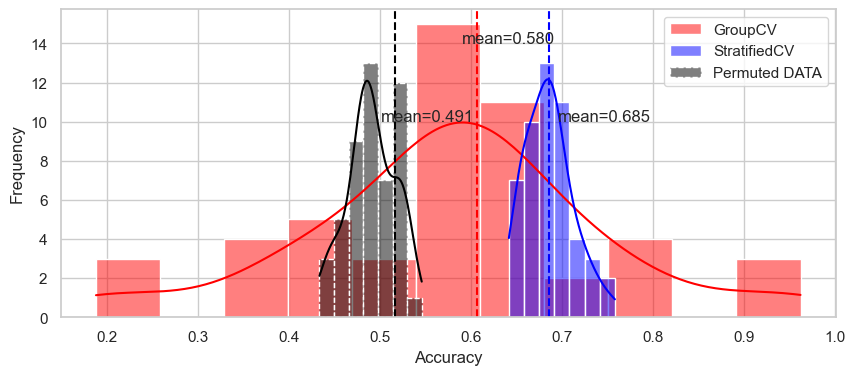

In [76]:
sns.set(style='whitegrid')
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(scores_, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(stratified, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(stratified).mean(), color='blue', linestyle='--')
plt.axvline(np.array(scores_).mean() + np.array(stratified).std(), color='red', linestyle='--')
plt.axvline(np.array(scores).mean() + np.array(scores).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(stratified).mean() + 0.01, 10, f'mean={np.array(stratified).mean():.3f}', fontsize=12)
plt.text(np.array(scores_).mean() + 0.01, 14, f'mean={np.array(scores_).mean():.3f}', fontsize=12)
plt.text(np.array(scores).mean() + 0.01, 10, f'mean={np.array(scores).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### EC vs. EO classification

In [ ]:
def open_data(path, sub=19, ch=27, seg_size=512):
    xarray = xr.open_dataarray(path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[sub])
    ids = take_ids(x.subject)
    x = x.to_numpy()[:, ch, :]
    x = torch.tensor(x).unsqueeze(1).unfold(-1, seg_size, seg_size).permute(0, 2, 1, 3).flatten(0, 1).permute(0, 2, 1)
    return x, ids

In [179]:
# open eyes open data
x_eo, ids_eo = open_data('data/LEMON_data/eeg_EO_Processed_50sub.nc5', ch=0, sub=[0, 1, 3, 4])
x_ec, ids_ec = open_data('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', ch=0, sub=[0, 1, 3, 4])

# concatenate the data with their labels
x = np.concatenate((x_eo, x_ec), axis=0)
labels = np.array([0]*x_eo.shape[0] + [1]*x_ec.shape[0])
groups = np.concatenate((ids_eo.repeat(len(x_eo)//4), ids_ec.repeat(len(x_ec)//4)))
len(x), len(labels), len(groups)

(960, 960, 960)

In [180]:
# upload the model
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=64)
wgan_gp.load_weights('tmp/keras_models/new_wgan_ch-Fp1_n-sub-1_epo-1k.model.keras')
critic = wgan_gp.critic
model = keras.Model(inputs=critic.layers[0].input, outputs=critic.layers[-2].output)
features = model(x).cpu().detach().numpy()

In [166]:
perm = torch.randperm(len(labels))
labels = labels[perm]

In [184]:
cv = GroupShuffleSplit(n_splits=100, test_size=0.2)

cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2)
pipe = Pipeline(steps=[
    # ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='linear', class_weight='balanced')),
])

stratified = cross_val_score(pipe, features, labels, cv=cv, groups=groups, n_jobs=-1)

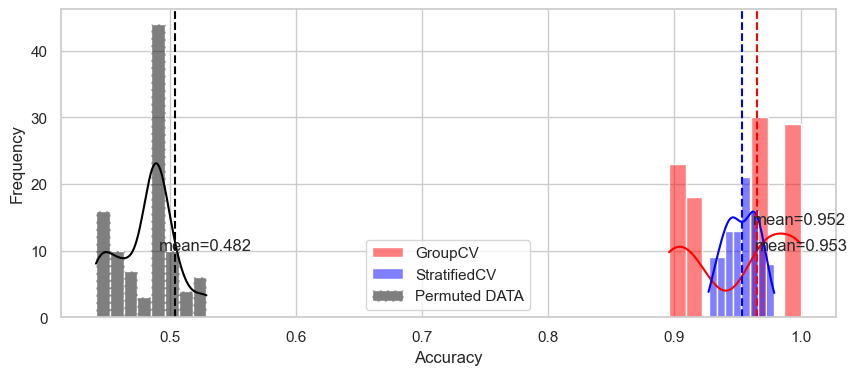

In [185]:
sns.set(style='whitegrid')
import seaborn as sns

plt.figure(figsize=(10, 4))
sns.histplot(scores_, kde=True, legend=True, color='red', label='GroupCV')
sns.histplot(stratified, kde=True, legend=True, color='blue', label='StratifiedCV')
sns.histplot(scores, kde=True, legend=True, color='black', label='Permuted DATA', linestyle='--')
# Add mean and std to the plot
plt.axvline(np.array(stratified).mean(), color='blue', linestyle='--')
plt.axvline(np.array(scores_).mean() + np.array(stratified).std(), color='red', linestyle='--')
plt.axvline(np.array(scores).mean() + np.array(scores).std(), color='black', linestyle='--')
# add text mean
plt.text(np.array(stratified).mean() + 0.01, 10, f'mean={np.array(stratified).mean():.3f}', fontsize=12)
plt.text(np.array(scores_).mean() + 0.01, 14, f'mean={np.array(scores_).mean():.3f}', fontsize=12)
plt.text(np.array(scores).mean() + 0.01, 10, f'mean={np.array(scores).mean():.3f}', fontsize=12)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.legend()

### Combine two models for classification

In [44]:
# gender classification
ch_list = ['Fp1']
ch_ids = find_channel_ids(xarray, ch_list)
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
f_ids = np.where(xarray.gender == 1)[0][:5]
m_ids = np.where(xarray.gender == 2)[0][:5]
# choose random female subjects
# f_ids = np.random.choice(f_ids, 5, replace=False)
# m_ids = np.random.choice(m_ids, 5, replace=False)
xf = xarray.sel(subject=xarray.subject[f_ids])
xm = xarray.sel(subject=xarray.subject[m_ids])
xf_ids, xm_ids = take_ids(xf.subject).repeat(120), take_ids(xm.subject).repeat(120)  # TODO: 120 should be deduced from the data
xf = torch.tensor(xf.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
xm = torch.tensor(xm.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf, xm), axis=0)
labels = np.array([0]*xf.shape[0] + [1]*xm.shape[0])
sub_ids = np.concatenate((xf_ids, xm_ids))

# shuffle the data and labels in the same way
perm = torch.randperm(x.shape[0])
labels = labels[perm]
sub_ids = sub_ids[perm]
x = x[perm]

# upload the model
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=64)
wgan_gp.load_weights('tmp/keras_models/new_wgan_ch-Fp1_n-sub-1_epo-1k.model.keras')
critic1 = wgan_gp.critic
model1 = keras.Model(inputs=critic1.layers[0].input, outputs=critic1.layers[-2].output)
features1 = model1(x.float()).cpu().detach().numpy()

In [45]:
# gender classification
ch_list = ['O1']
ch_ids = find_channel_ids(xarray, ch_list)
xarray = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
f_ids = np.where(xarray.gender == 1)[0][:5]
m_ids = np.where(xarray.gender == 2)[0][:5]
# choose random female subjects
# f_ids = np.random.choice(f_ids, 5, replace=False)
# m_ids = np.random.choice(m_ids, 5, replace=False)
xf = xarray.sel(subject=xarray.subject[f_ids])
xm = xarray.sel(subject=xarray.subject[m_ids])
xf_ids, xm_ids = take_ids(xf.subject).repeat(120), take_ids(xm.subject).repeat(120)  # TODO: 120 should be deduced from the data
xf = torch.tensor(xf.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
xm = torch.tensor(xm.to_numpy()[:, ch_ids, :]).unfold(-1, 512, 512).permute(0, 2, 3, 1).flatten(0, 1)
x = torch.cat((xf, xm), axis=0)
labels = np.array([0]*xf.shape[0] + [1]*xm.shape[0])
sub_ids = np.concatenate((xf_ids, xm_ids))

# shuffle the data and labels in the same way
perm = torch.randperm(x.shape[0])
labels = labels[perm]
sub_ids = sub_ids[perm]
x = x[perm]

# upload the model
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=64)
wgan_gp.load_weights('tmp/keras_models/new_wgan_ch-O1_sub-3.model.keras')
critic1 = wgan_gp.critic
model2 = keras.Model(inputs=critic1.layers[0].input, outputs=critic1.layers[-2].output)
features2 = model1(x.float()).cpu().detach().numpy()

In [46]:
features = np.concatenate((features1, features2), axis=1)

(1200, 128)

In [ ]:
model3 = keras.Sequential([
    keras.Input(shape=(64*2,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model3.compile(optimizer=keras.optimizers.Adam(0.0001), loss=keras.losses.BinaryCrossentropy(from_logits=True))
history = model3.fit(features, labels, epochs=100, batch_size=32, validation_split=0.2)

In [74]:
features = np.concatenate((features1, features2), axis=1)

In [75]:
model_new = keras.Model(inputs=model3.layers[0].input, outputs=model3.layers[-2].output)
features = model_new(features).cpu().detach().numpy()

In [86]:
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='rbf', class_weight='balanced', C=0.1)),
])

# cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2)
cv = GroupShuffleSplit(n_splits=100, test_size=0.2)
scores = cross_val_score(pipe, features, labels, cv=cv, groups=sub_ids, n_jobs=-1)
scores.mean(), scores.std()

(0.48487500000000006, 0.17953707350820022)

**Observations**

The reason for an unstable training loss might be that the architecture of the critic and the generator are both strong so they might closely compete. And this is really interesting that we have mode collapse, generator does not simply know what to produce! or maybe it's because of the maxpooling! I should remove maxpooling! instead of maxpooling, strided convolution can be used as in the DCGAN.

## BenchMarks
### AWS Chronous

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv")

# context must be either a 1D tensor, a list of 1D tensors,
# or a left-padded 2D tensor with batch as the first dimension
context = torch.tensor(df["#Passengers"])
prediction_length = 12
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(df["#Passengers"], color="royalblue", label="historical data")
plt.plot(forecast_index, median, color="tomato", label="median forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% prediction interval")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("amazon/chronos-t5-large")
# model = AutoModelForSeq2SeqLM.from_pretrained("amazon/chronos-t5-tiny")

## Sine waves 
Investigate similarities of t-SNE components between real and fake data when training with Sine waves 

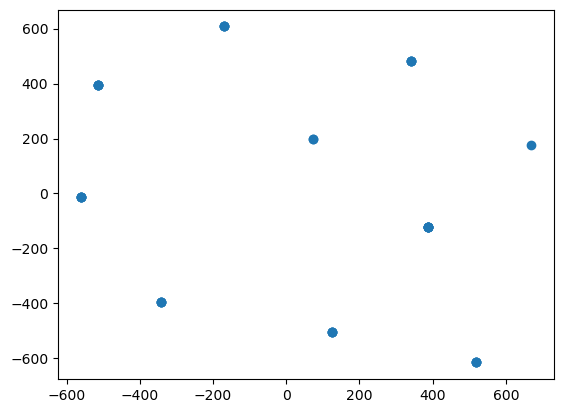

In [ ]:
# sine data
from src.EEGModalNet.data.mock_temporal_data import MockTemporalData
data = MockTemporalData(n_samples=40, n_features=2, n_timepoints=1000, clip=True)
x = np.zeros((40, 1000, 1))
for i in range(40):
    x[i, :, 0] = data()[0][i, :, 0]

tsne = TSNE(n_components=2, verbose=0)
tsne_results = tsne.fit_transform(x.mean(axis=2))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])

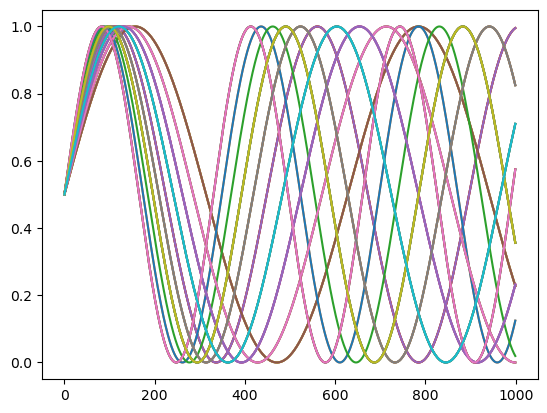

In [ ]:
for i in range(40):
    plt.plot(x[i, :, 0])
plt.show()

In [ ]:
from src.EEGModalNet.models.WGAN import WGAN_GP
model = WGAN_GP(time_dim=100, feature_dim=4, latent_dim=64)
model.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
              g_optimizer=keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9),
              gradient_penalty_weight=1)
history = model.fit(x, epochs=1000)

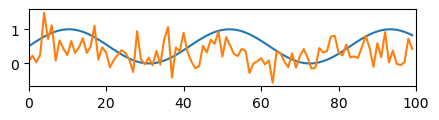

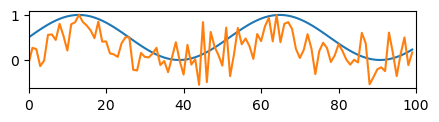

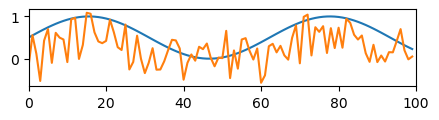

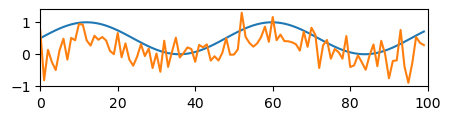

In [ ]:
x_gen = model.generator(keras.random.normal((40, 64))).cpu().detach().numpy()
for seg in range(4):
    plt.figure(figsize=(5, 1))
    plt.plot(x[0, :, seg], label='real')
    plt.plot(x_gen[0, :, seg], label='generated')
    plt.xlim(0, 100)
    # plt.legend()
    plt.show()

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
x_flat = x.mean(axis=0)
x_flat_hat = x_gen.mean(axis=0)
x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.000s...
[t-SNE] Computed neighbors for 200 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.362289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.460228
[t-SNE] KL divergence after 900 iterations: 0.435252


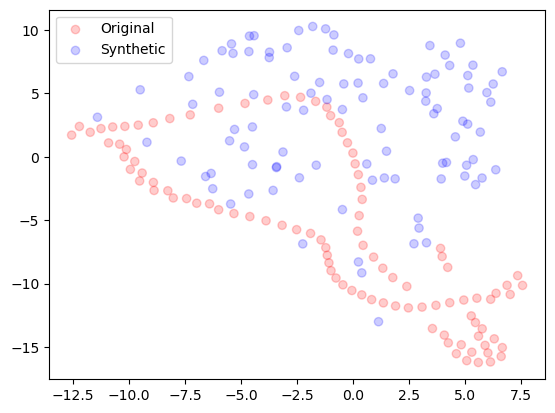

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30)
tsne_results = tsne.fit_transform(x_flat_final)
colors = ["red" for i in range(100)] + ["blue" for i in range(100)]
plt.scatter(tsne_results[:100, 0], tsne_results[:100, 1], c = colors[:100], alpha = 0.2, label = "Original")
plt.scatter(tsne_results[100:, 0], tsne_results[100:, 1], c = colors[100:], alpha = 0.2, label = "Synthetic")
plt.legend()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 200 samples in 0.004s...
[t-SNE] Computed neighbors for 200 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 0.324033
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.707298
[t-SNE] KL divergence after 900 iterations: 0.434889


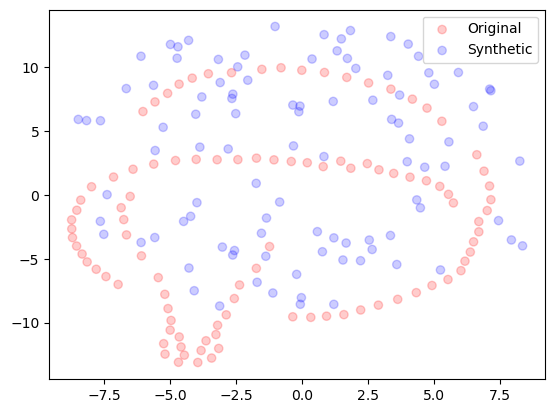

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=30)
tsne_results = tsne.fit_transform(x_flat_final)
colors = ["red" for i in range(100)] + ["blue" for i in range(100)]
plt.scatter(tsne_results[:100, 0], tsne_results[:100, 1], c = colors[:100], alpha = 0.2, label = "Original")
plt.scatter(tsne_results[100:, 0], tsne_results[100:, 1], c = colors[100:], alpha = 0.2, label = "Synthetic")
plt.legend()

## Conditional WGAN

In [ ]:
from src.EEGModalNet.models.cwgan import ConditionalWGAN
from src.EEGModalNet.models.cgan import ConditionalGAN
import torch

In [ ]:
# data
data = LEMONEEGDataModule(n_subjects=10, shuffling='split_shuffle', split_type='subject', segment_size=256,
                          patching=True).prepare_data()
x = data.train_dataset['x'][:500, :, :2]
y = data.train_dataset['y'][:500].argmax(axis=1)
# data = {'x': x, 'y': y}

# x = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5')
# x = x.sel(subject=x.subject[-2:]).to_numpy()
# x = x[:, [27, 29], 3000:3500]
# x = torch.tensor(np.moveaxis(x, 2, 1)).repeat(50, 1, 1)
# y = torch.tensor([0, 1]).repeat(50)
# data = (x, y)


# # model
cgan = ConditionalGAN(time_dim=256, feature_dim=2, latent_dim=64, n_classes=2)

generator_optimizer = keras.optimizers.Adam(0.001, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = keras.optimizers.Adam(0.004, beta_1=0.5, beta_2=0.9)

cgan.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True),
             d_optimizer=discriminator_optimizer,
             g_optimizer=generator_optimizer)

history = cgan.fit(x, y, epochs=50)

>>> Shuffling data after splitting
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - d_loss: 0.6506 - g_loss: 0.7943
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - d_loss: 0.6611 - g_loss: 0.7568
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - d_loss: 0.7332 - g_loss: 0.6616
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - d_loss: 0.7332 - g_loss: 0.6600
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - d_loss: 0.7332 - g_loss: 0.6538
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - d_loss: 0.7665 - g_loss: 0.7720
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - d_loss: 0.7332 - g_loss: 0.6555
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - d_loss: 0.7332 - g_loss: 0.6621
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - d_loss: 0.7332 - g_loss: 0.6597
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - d_loss: 0.7332 - g_loss: 0.6654
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - d_loss: 0.7332 - g_loss: 0.6628
Epoch 12/50
16/16 ━━━━━━━━━━

In [ ]:
import torch
from keras import ops
y_ = torch.tensor(y).unsqueeze(1).repeat(1, 256, 1)
data_real = ops.concatenate([torch.tensor(x), y_], axis=-1)

noise = keras.random.normal((1680, 64))
data_fake = cwgan.generator(ops.concatenate([noise, torch.tensor(y)], axis=1))
cwgan.discriminator(ops.concatenate([data_fake, y_], axis=-1))

## Visualize 2d manifold using tSNE

In [ ]:
from sklearn.manifold import TSNE
from src.EEGModalNet.models.WGAN import WGAN_GP

In [ ]:
# Create a model that outputs the intermediate layer
intermediate_layer_model = keras.Model(inputs=cgan.generator.model.get_layer('dense_5').input,
                                       outputs=cgan.generator.model.get_layer('dense_6').output)

latent_vectors = np.random.normal(size=(500, 64 + 2))

# Get the intermediate layer output
intermediate_features = intermediate_layer_model.predict(latent_vectors)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


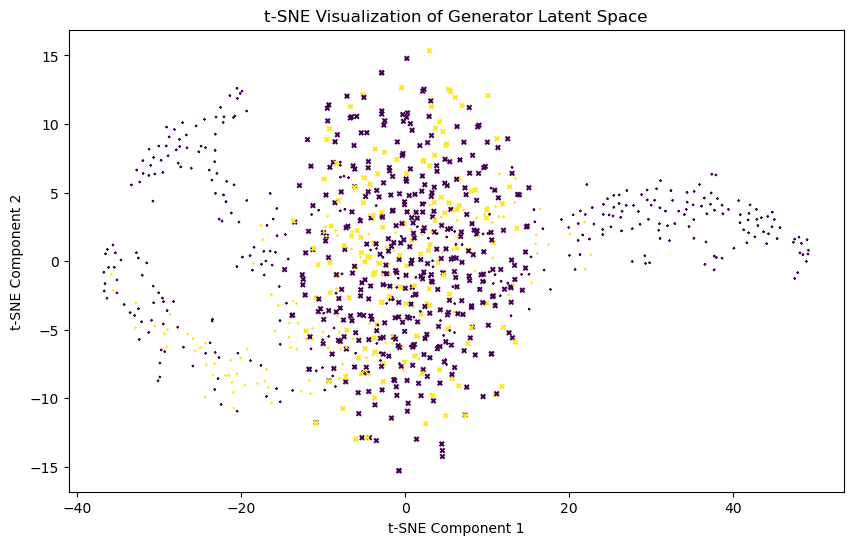

In [ ]:
# intermediate_discriminator = keras.Model(inputs=cgan.discriminator.model.get_layer('flatten_1').input,
#                                         outputs=cgan.discriminator.model.get_layer('dense_7').output)

# intermediate_features_dis = intermediate_discriminator.predict(x)

# tsne = TSNE(n_components=2, random_state=42)
# tsne_results = tsne.fit_transform(intermediate_features)
# tsne_results_dis = tsne.fit_transform(intermediate_features_dis)
plt.figure(figsize=(10, 6))

# make it visible in the scatter plot that the tsne_results_dis are the discriminator's intermediate features
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, c=y, cmap='viridis', norm=plt.Normalize(0, 1), marker='x')
plt.scatter(tsne_results_dis[:, 0], tsne_results_dis[:, 1], s=1, c=y, cmap='viridis', marker='x')
plt.title('t-SNE Visualization of Generator Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

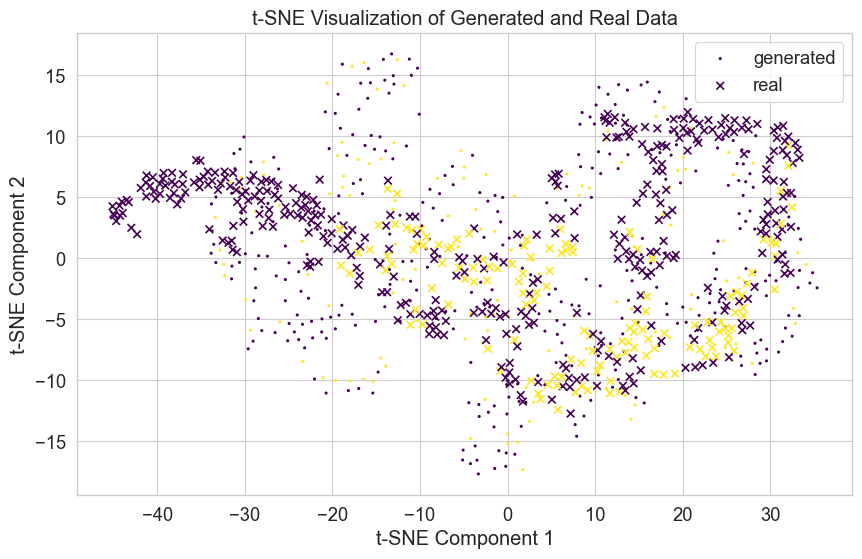

In [ ]:
# latent_vectors = np.random.normal(size=(500, 64 + 2))
# generated_data = cgan.generator.model(latent_vectors)

# # visualize T-sne for the generated data and the real data
# tsne = TSNE(n_components=2, random_state=None)
# tsne_results = tsne.fit_transform(generated_data.cpu().detach().numpy().mean(axis=1))
# tsne_results_real = tsne.fit_transform(x.mean(axis=1))

# sns.set(style='whitegrid')
sns.set_palette('viridis')
sns.set_context('paper', font_scale=1.5)

plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=2, c=y, cmap='viridis', label='generated', norm=plt.Normalize(0, 1))
plt.scatter(tsne_results_real[:, 0], tsne_results_real[:, 1], s=30, label='real', c=y, cmap='viridis', marker='x', norm=plt.Normalize(0, 1))
plt.title('t-SNE Visualization of Generated and Real Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


In [ ]:
# Function to interpolate between two latent vectors
def interpolate_vectors(z1, z2, num_steps=5):
    ratios = np.linspace(0, 1, num_steps)
    vectors = np.array([z1 * (1 - ratio) + z2 * ratio for ratio in ratios])
    return vectors

# Generate two random latent vectors
z1 = np.random.normal(size=(1, 64 + 2))
z2 = np.random.normal(size=(1, 64 + 2))

# Interpolate between the vectors
interpolated_vectors = interpolate_vectors(z1, z2, num_steps=10)

# Calculate power spectrum of the interpolated vectors
generated_samples = cgan.generator.model.predict(interpolated_vectors.squeeze())
# generated_samples = np.abs(np.fft.rfft(interpolated_data.squeeze(), axis=1))

# # # Generate samples from the interpolated vectors
# generated_samples = cgan.generator.model.predict(interpolated_vectors.squeeze())

# Plot the generated samples
def plot_generated_samples(samples):
    num_samples = samples.shape[0]
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 20, 20))
    for i, ax in enumerate(axes):
        ax.imshow(samples[i], aspect='auto')
        ax.axis('off')
    plt.show()

# Reshape generated samples for plotting (assuming they are 2D)
generated_samples_reshaped = generated_samples.reshape((-1, 256, 2))
plot_generated_samples(generated_samples_reshaped)

NameError: name 'np' is not defined

## TEST1: cWGAN

In [ ]:
data = LEMONEEGDataModule(n_subjects=50, shuffling='split_shuffle', split_type='subject', segment_size=256,
                          patching=False, stratified=False, train_ratio=0.9).prepare_data()
x = data.train_dataset['x'][:300, :, [27, 29]]
y = data.train_dataset['y'][:300]

>>> Shuffling data after splitting


In [ ]:
y = data.train_dataset['y'][:1000]
x = data.train_dataset['x'][:1000, :, [27, 29]]
np.unique(y.argmax(axis=1), return_counts=True)[1] / len(y)

array([0.566, 0.434])

In [ ]:
import keras
from keras import ops, layers
import torch

time = 256
feature = 2
input_shape = (time, feature)
latent_dim = 64
num_classes = 2
d_loss_tracker = keras.metrics.Mean(name='d_loss')
g_loss_tracker = keras.metrics.Mean(name='g_loss')
accuracy_tracker = keras.metrics.BinaryAccuracy(name='accuracy')

generator = keras.Sequential([
    keras.Input(shape=(latent_dim + num_classes,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(time * feature),
    layers.Reshape(input_shape)
], name='generator')

discriminator = keras.Sequential([
    keras.Input(shape=(input_shape[0], input_shape[1] + num_classes)),
    layers.Flatten(),
    layers.Dense(time * feature, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1 + num_classes, activation='softmax')  # TODO: differences.
], name='discriminator')

In [ ]:
d_optimizer = keras.optimizers.Adam(0.0001)
g_optimizer = keras.optimizers.Adam(0.0001)
def gradient_penalty(real_data, fake_data):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, 1).to(real_data.device)
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    prob_interpolated = discriminator(interpolated)

    gradients = torch.autograd.grad(
        outputs=prob_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(prob_interpolated.size()).to(real_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.view(batch_size, -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    return gradient_penalty


real_data, real_labels = torch.tensor(x), torch.tensor(y)
batch_size = real_data.shape[0]

noise = keras.random.normal((batch_size, latent_dim),
                            mean=0, stddev=1)

real_data = real_data.to(noise.device)
real_labels = real_labels.to(noise.device)

# update the real_labels dimension to be able to concatenate with the data
real_labels_reshaped = real_labels.unsqueeze(1).repeat(1, time, 1)

# train discriminator
fake_data = generator(torch.cat((noise, real_labels), dim=1)).detach()
real_pred = discriminator(torch.cat((real_data, real_labels_reshaped), dim=-1))
fake_pred = discriminator(torch.cat((fake_data, real_labels_reshaped), dim=-1))
gp = gradient_penalty(torch.cat((real_data, real_labels_reshaped), dim=-1),
                      torch.cat((fake_data, real_labels_reshaped), dim=-1).detach())

label_loss = keras.losses.BinaryCrossentropy(from_logits=True)(real_labels, real_pred[:, 1:])
label_loss2 = keras.losses.binary_crossentropy(real_labels, real_pred[:, 1:])
d_loss = (fake_pred.mean() - real_pred.mean()) + gp * 1 
d_loss.backward()
grads = [v.value.grad for v in discriminator.trainable_weights]
with torch.no_grad():
    d_optimizer.apply(grads, discriminator.trainable_weights)

# train generator
noise = keras.random.normal((batch_size, latent_dim),
                            mean=0, stddev=1)

fake_pred = discriminator(torch.cat((generator(torch.cat((noise, real_labels), dim=1)), real_labels_reshaped), dim=-1))
g_loss = -fake_pred.mean()
g_loss.backward()
grads = [v.value.grad for v in generator.trainable_weights]
with torch.no_grad():
    g_optimizer.apply(grads, generator.trainable_weights)

print(g_loss.cpu().detach().numpy(), d_loss.cpu().detach().numpy())

-0.33333334 1.0


## Eyes closed data

In [ ]:
# Helper functions
# clamp
def clamp_eeg(data, axis=2, deviation=20):
    """Clamp EEG data proportional to the standard deviation of each channel."""
    # container for clamped data
    data_clamped = np.zeros_like(data)
    upper_dev = data.mean(axis=axis) + data.std(axis=axis) * deviation
    lower_dev = data.mean(axis=axis) - data.std(axis=axis) * deviation
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            data_clamped[i, j, :] = np.clip(data[i, j, :], lower_dev[i, j], upper_dev[i, j])
    return data_clamped

def print_min_max(data, lower_dev, upper_dev, sub, channel):
    """Prints the min and max of a channel and checks if it would be clamped by the clamp_eeg function
    This is used to check if the clamp function is working as expected."""
    if data[sub, channel, :].min() < lower_dev[sub, channel] or data[sub, channel, :].max() > upper_dev[sub, channel]:
        print(f'Data: {sub}, {channel}: Min={data[sub, channel, :].min()}, Max={data[sub, channel, :].max()}',
              f'Bounderies: Lower={lower_dev[sub, channel]}, Higher={upper_dev[sub, channel]}')

In [ ]:
# open dataset
import xarray as xr
from sklearn.preprocessing import RobustScaler
import numpy as np
da_name = 'eye_open'
ds = xr.open_dataset('data/LEMON_data/eeg_eo_ec.nc5', engine='h5netcdf')
subject_ids = ds.subject.values
da = ds[da_name]
da = da.sel(subject=subject_ids[:50])
del ds

# convert to numpy array
data_eo = da.to_numpy()
del da

# baseline correction
data_eo = data_eo - data_eo[:, :, :int(128*0.5)].mean(axis=2, keepdims=True)

# normalize
data_eo = np.array(
          [RobustScaler().fit_transform(data_eo[i, :, :]) for i in range(data_eo.shape[0])]
        )
print(data_eo.min(), data_eo.max())

# clamp
data_eo = clamp_eeg(data_eo)

# save
data_eo = xr.DataArray(data_eo, dims=['subject', 'channel', 'timestep'])
data_eo.coords['subject'] = subject_ids[:50]
# data_eo.to_netcdf('data/eeg_EO_Processed_50sub.nc5', engine='h5netcdf')

-80.50038023976872 92.22402141932476


In [ ]:
EC = xr.open_dataarray('data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5', engine='h5netcdf')
EC = EC.sel(subject=EC.subject[:50])

In [ ]:
# create a dataset with both EO and EC data
data = xr.Dataset({'EO': data_eo, 'EC': EC})

In [ ]:
data = xr.Dataset({'EO': data_eo, 'EC': EC})

## Treating EEG as video
### Prepare data

In [25]:
import mne
import numpy as np
import xarray as xr
import scipy.io
from matplotlib import pyplot as plt

In [26]:
# read epochs data with mne
epochs = mne.read_epochs('data/OTKA/sub-01_ses-01_task-baseline1_proc-clean_epo.fif', verbose=False)
epochs = epochs.pick('eeg')
epochs.drop_channels(['M1', 'M2', 'Iz'])
x = epochs.get_data(copy=False)[2:-2].mean(axis=-1)
maxim = abs(x.mean(0)).max()
std = epochs.get_data(copy=False)[2:].std()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
for i in range(2):
    im, _ = mne.viz.plot_topomap(x[1*i:1*i+1].mean(0), pos=epochs.info, ch_type='eeg', show=False, size=4, contours=2, cmap='RdBu_r',
                                 vlim=(-maxim-std/2, maxim+std/2), res=128)
    plt.show()
    # save image
    plt.savefig(f'data/topomap_{i}.png', dpi=128)

In [6]:
def set_channel_positions(raw, localizer_dir):
    """ This function sets the channel positions for individual EEG recordings
     based on the channel positions from the localizer """

    channels = scipy.io.loadmat(localizer_dir)
    channels = channels['Channel'][0]

    def read_ch_name(channels, i):
        return channels[i][0][0].split('_')[-1].lower()
    ch_dict = {}
    for i in range(len(channels)):
        ch_dict[read_ch_name(channels, i)] = channels[i][3].reshape(-1)

    ch_names = [raw.ch_names[i].lower() for i in range(len(raw.ch_names))]

    # adding channel positions to raw data
    for ch in ch_names:
        raw.info['chs'][ch_names.index(ch)]['loc'][:3] = ch_dict[ch]
        raw.info['chs'][ch_names.index(ch)]['loc'][3:6] = 0

    return raw

raw = mne.io.read_raw_brainvision('data/LEMON_data/raw/sub-010004/RSEEG/sub-010004.vhdr', eog=['VEOG'])
localizer_dir = 'data/LEMON_data/digitized_ch-positions/sub-032304.mat'
raw = set_channel_positions(raw, localizer_dir)

Extracting parameters from data/LEMON_data/raw/sub-010004/RSEEG/sub-010004.vhdr...
Setting channel info structure...


### Convert images to tensors

In [14]:
from PIL import Image
import torch
from torchvision import transforms, utils
from pathlib import Path
height, width = 256, 256

def load_and_preprocess_image(img_path, target_size=(height, width)):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),  # Converts to (channel, height, width) and normalizes to [0, 1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Optional
    ])
    img_tensor = transform(img)
    return img_tensor

images = []
for img_path in Path('data/test').glob('*.png'):
    images.append(load_and_preprocess_image(img_path))

frames = len(list(Path('data/test').glob('*.png')))

# Stack images to create a single tensor with shape (num_frames, channel, height, width)
images_tensor = torch.stack(images)

# Add a batch dimension to create the final tensor with shape (sample, num_frames, channel, height, width)
video_tensor = images_tensor.unsqueeze(0)

# # Ensure the shape is (sample, num_frames, channel, height, width)
assert video_tensor.shape == (1, frames, 3, height, width)  # assuming RGB images


print("PyTorch video tensor shape:", video_tensor.shape)
# torch.save(video_tensor, 'data/topomap_video.pth')

PyTorch video tensor shape: torch.Size([1, 289, 3, 256, 256])


In [3]:
video_tensor = video_tensor.permute(0, 1, 3, 4, 2)

In [39]:
from keras import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, Conv1D, GlobalAveragePooling1D

frames = 128
critic = Sequential([
            Input(shape=(frames, height, width, 3)),
            # Apply Conv2D to each frame independently
            TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))),
            TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))),
            TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', strides=(2, 2))),
            # Flatten each frame's feature maps
            TimeDistributed(Flatten()),
            # Now the shape should be (batch_size, num_frames, flattened_features)
            # Apply Conv1D across the frames
            Conv1D(filters=64, kernel_size=3, activation='relu'),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])

critic.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_160            │ (None, 128, 32, 32,    │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_161            │ (None, 128, 16, 16,    │        18,496 │
│ (TimeDistributed)               │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_162            │ (None, 128, 8, 8, 64)  │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_163            │ (None, 128, 4096)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_42 (Conv1D)              │ (None, 126, 64)        │       786,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_18     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 842,881 (3.22 MB)

 Trainable params: 842,881 (3.22 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
from keras.layers import Conv2DTranspose, Reshape, UpSampling2D, BatchNormalization, ReLU, Dense, Input, Conv1D, UpSampling1D
def build_generator(latent_dim, num_frames, height, width, channels=3):
    model = Sequential()

    model.add(Input(shape=(latent_dim,)))

    # Fully connected layer to reshape input into a small tensor
    model.add(Dense(128, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Reshape((num_frames // 8, 256//16)))

    # Upsampling in the temporal dimension
    model.add(UpSampling1D(size=2))
    model.add(Conv1D(32, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(UpSampling1D(size=2))
    model.add(Conv1D(64, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(UpSampling1D(size=2))
    model.add(Conv1D(128, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Conv1D(height // 8 * width // 8 * 3, kernel_size=3, padding='same'))
    model.add(BatchNormalization())
    model.add(ReLU())

    model.add(Reshape((num_frames, height // 8, width // 8, 3)))
    
    # Upsampling in the spatial dimensions
    model.add(TimeDistributed(UpSampling2D(size=(2))))
    model.add(TimeDistributed(Conv2D(4, kernel_size=(3, 3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(ReLU()))
    
    model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
    model.add(TimeDistributed(Conv2D(8, kernel_size=(3, 3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(ReLU()))

    model.add(TimeDistributed(UpSampling2D(size=(2, 2))))
    model.add(TimeDistributed(Conv2D(16, kernel_size=(3, 3), padding='same')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(ReLU()))

    model.add(TimeDistributed(Conv2D(3, kernel_size=(3, 3), padding='same')))

    return model

latent_dim = 100
generator = build_generator(latent_dim=100, num_frames=128, height=64, width=64)
generator(keras.random.normal((1, latent_dim))).shape

torch.Size([1, 128, 64, 64, 3])

In [17]:
video_tensor = video_tensor[:, :128]

In [28]:
keras.config.disable_traceback_filtering()

In [66]:
# from src.EEGModalNet.models.ViGAN import ViT_GAN

# # model
# model = ViT_GAN(frames=128, height=64, width=64, channels=3, latent_dim=64,)
# model.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
#               g_optimizer=keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9),
#               gradient_penalty_weight=1)

# training
history = model.fit(video_tensor, epochs=50)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - d_loss: 0.0284 - g_loss: -0.0078
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.7695 - g_loss: -0.1759
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.3918 - g_loss: -0.2932
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.7582 - g_loss: -0.1239
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.1573 - g_loss: -0.0261
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.4240 - g_loss: -0.3000
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.8810 - g_loss: -0.9530
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.9730 - g_loss: -0.9964
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.9966 - g_loss: -0.9870
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.9242 - g_loss: -0.8354
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.5830 - g_loss: -0.0063
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - d_loss: 0.8716 - g_loss: -0.0227
Epoch 13/50
1

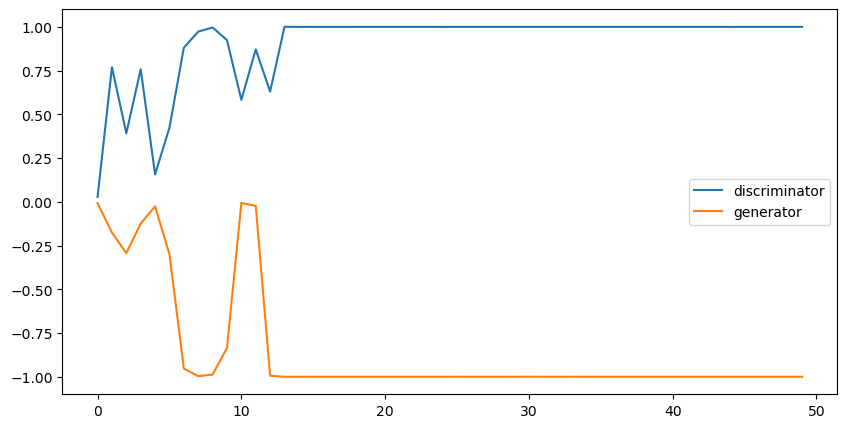

In [67]:
plot_history(history)

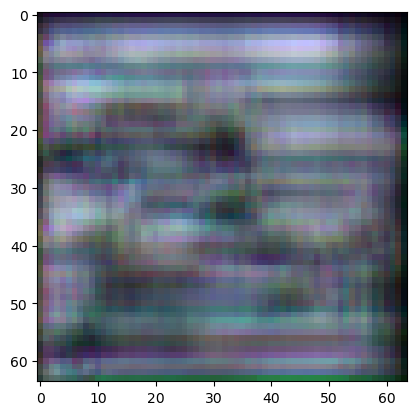

In [69]:
out = model.generator(keras.random.normal((1, 64))).cpu().detach()
img_grid = utils.make_grid(out[0, 1], normalize=True, scale_each=True) 
plt.imshow(img_grid)

In [ ]:
# make sure transformation of the image would not change it
img_tensor = load_and_preprocess_image('data/test/topomap_11.png')
img_grid = utils.make_grid(img_tensor, normalize=True, scale_each=True)  # Create a grid of images
img_grid_np = img_grid.permute(1, 2, 0).numpy()  # Convert the grid to a numpy array
# Display the grid
plt.imshow(img_grid_np)
plt.axis('off')
plt.show()

"UserWarning: The operator 'aten::_foreach_mul_.Scalar' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403251597/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch._foreach_mul_(m_list, self.beta_1)"

## Using preprocessed data

In [ ]:
import numpy as np
from pathlib import Path
import torch
import mne
data_path = 'data/LEMON_data/EEG_Preprocessed/'

data_ec = {}

# read epochs data with mne
for i in Path(data_path).glob('sub-*'):
    sub_id = i.stem
    raw_ec = mne.io.read_raw_eeglab(i / f'{sub_id}_EC.set', verbose=False)
    if 'Cz' in raw_ec.ch_names:
        raw_ec = raw_ec.pick(['Cz']).get_data()
        data_ec[sub_id] = raw_ec

data = {k: torch.tensor(v).unfold(1, 512, 512).permute(1, 2, 0) for k, v in data_ec.items()}
del data_ec

# create sub_ids
sub_ids = np.array([])
for i, k in enumerate(data.keys()):
    sub_ids = np.concatenate((sub_ids, np.array([i]*data[k].shape[0])))

sub_ids = sub_ids[:, np.newaxis]

# sanity check
print(np.unique(sub_ids, return_counts=True))

data_flat = np.zeros([1, 512, 1])
for k in data.keys():
    data_flat = np.concatenate((data_flat, data[k]), axis=0)
data_flat = data_flat[1:]
del data

In [88]:
data = {'x': data_flat, 'sub': sub_ids}

In [90]:
from src.EEGModalNet.models.WGAN import WGAN_GP

# model
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=64)
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.0001, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.0004, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=1)

# training
history = wgan_gp.fit(data, epochs=30)

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 197ms/step - d_loss: -0.0014 - g_loss: -0.0183
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - d_loss: -0.0013 - g_loss: -0.0179
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 196ms/step - d_loss: -0.0014 - g_loss: -0.0175
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - d_loss: -0.0015 - g_loss: -0.0170
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - d_loss: -0.0014 - g_loss: -0.0168
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - d_loss: -0.0014 - g_loss: -0.0163
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 33s 192ms/step - d_loss: -0.0015 - g_loss: -0.0158
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - d_loss: -0.0015 - g_loss: -0.0155
Epoch 9/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 193ms/step - d_loss: -0.0014 - g_loss: -0.0152
Epoch 10/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - d_loss: -0.0015 - g_loss: -0.0148
Epoch 11/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 34s 194ms/step - d_loss: -0.0014 - g_loss: -0.01

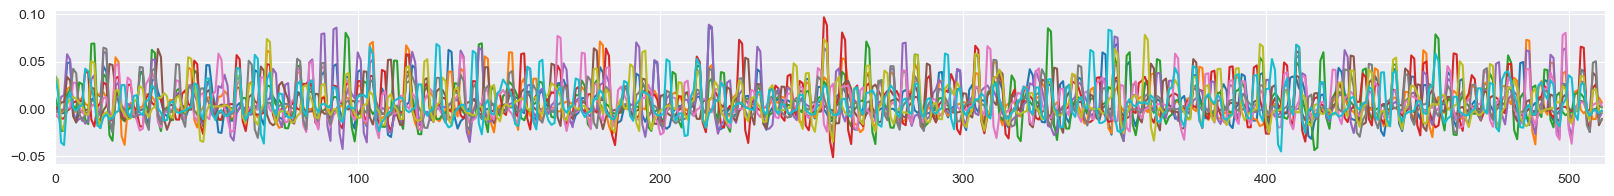

In [95]:
x_gen = wgan_gp.generator(keras.random.normal((20, 64))).cpu().detach().numpy()

plot_overlap(x_gen, n_seg=10)